# ハイスピードカメラ映像からの抽出

In [1]:
video_dir = "Chips2-2200Hz-Mary_MIDI-input.avi"

In [2]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write
import torch
import torchaudio
import numpy as np
import pandas as pd

In [3]:
'''
All functions written here is an implementation of the paper on 
Visual Microphone(http://people.csail.mit.edu/mrub/VisualMic/) 
by MIT. The algorithm and functions are inspired by the MATLAB code
provided by MIT.
'''

'\nAll functions written here is an implementation of the paper on \nVisual Microphone(http://people.csail.mit.edu/mrub/VisualMic/) \nby MIT. The algorithm and functions are inspired by the MATLAB code\nprovided by MIT.\n'

In [223]:
class VM:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.sr = 2200

    def align(self, x, y):
        # tshift = np.argmax(np.convolve(x, np.flip(y)))
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)
        
    def plot_spectogram(self, x, fs=2200, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr=0):
        if sr==0:
            sr = self.sr
        # write(file_name, sr, x)
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor, sample_rate=2200):
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
       
        suc,frame = video.read() #reading first frame and considering it reference frame
       
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame
        
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        # first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        iter=1
        time_start = time()
        time_present=time()
        
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            # pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)
            
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
                
            suc,frame=video.read()
            time_present = time()
            
            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            # if iter==2200:
            #     break
            
        for band in pyramid.keys():
            # print(recovered_signal[band])
            plt.plot(range(1, len(recovered_signal[band])+1), recovered_signal[band])
            plt.show()
            self.plot_spectogram(recovered_signal[band])
            plt.show()
        # return      
        
        recov_sound=np.zeros(nframes)

        for rsignal in recovered_signal.values():
            if rsignal == recovered_signal['residual_lowpass']:
                continue
            recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
            # recov_sound+=self.align(np.array(rsignal),np.array(recov_sound)) 

        plt.plot(range(1, len(recov_sound)+1), recov_sound)
        plt.show()
        
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        
        return filtered_sound

In [224]:
vm = VM(video_dir)

Progress done: 1.3129217761205787% after 3.591404914855957s.
Progress done: 2.6258435522411574% after 7.201810359954834s.
Progress done: 3.938765328361736% after 10.82105278968811s.
Progress done: 5.251687104482315% after 14.43470048904419s.
Progress done: 6.564608880602894% after 18.04492449760437s.
Progress done: 7.877530656723472% after 21.609296321868896s.
Progress done: 9.190452432844051% after 25.21961498260498s.
Progress done: 10.50337420896463% after 28.831944227218628s.
Progress done: 11.816295985085208% after 32.50080060958862s.
Progress done: 13.129217761205789% after 36.12205719947815s.
Progress done: 14.442139537326366% after 39.72638154029846s.
Progress done: 15.755061313446944% after 43.327475786209106s.
Progress done: 17.067983089567523% after 46.9334020614624s.
Progress done: 18.380904865688102% after 50.53779578208923s.
Progress done: 19.69382664180868% after 54.14584755897522s.
Progress done: 21.00674841792926% after 57.508835792541504s.
Progress done: 22.31967019404

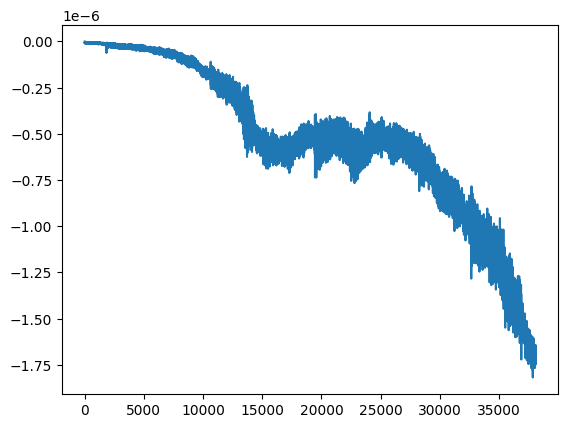

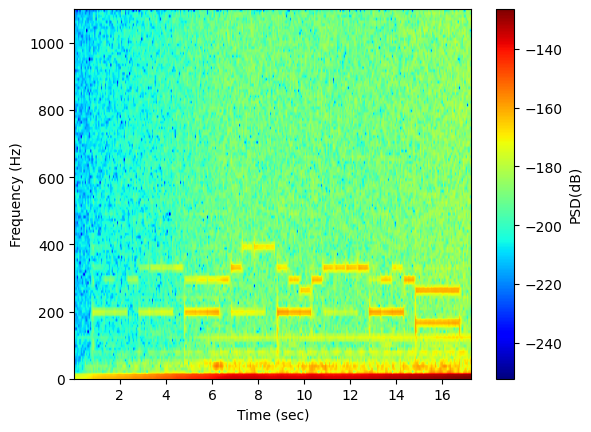

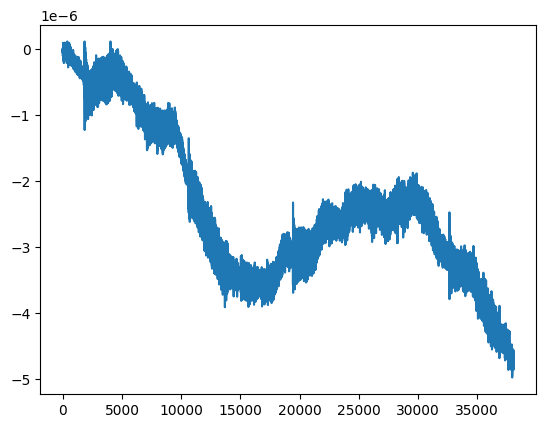

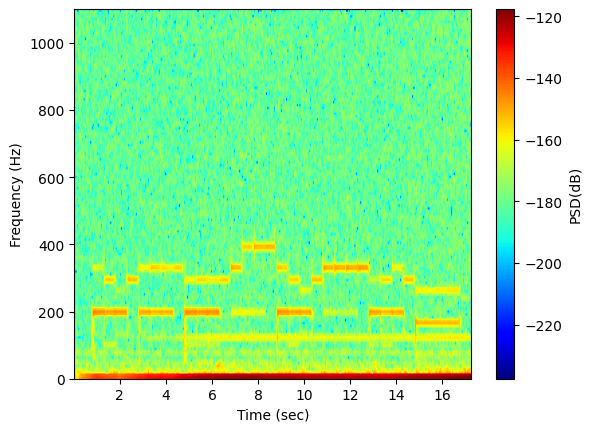

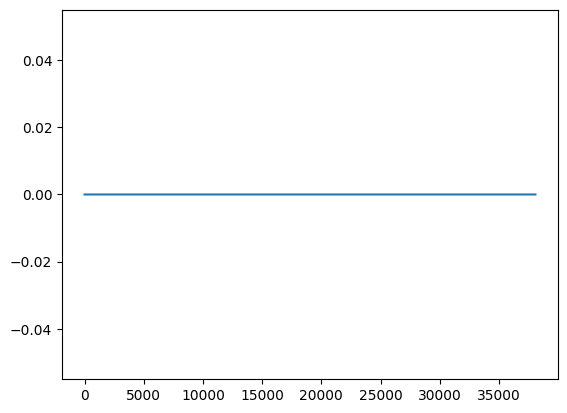

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


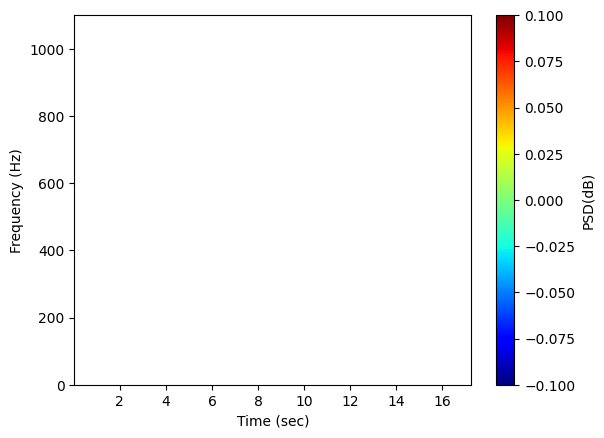

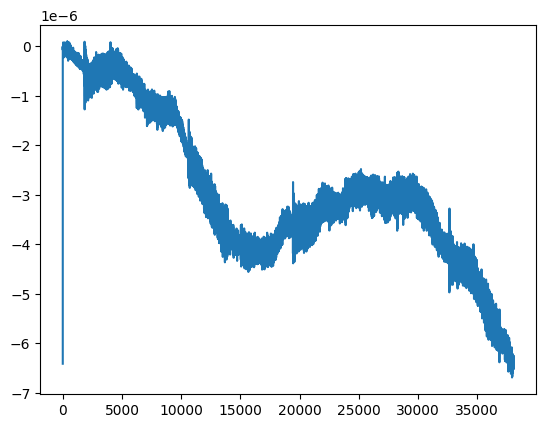

max: 1.7203504660600353e-06, mins: -5.4815708483757035e-06, rengev: 7.201921314435739e-06
     count      mean       std       min       25%       50%       75%  \
0  38083.0  0.000002  0.044704 -1.522252 -0.030739 -0.000176  0.030813   

        max  
0  0.477748  


In [225]:
x = vm.sound_from_video(1, 1, 0.1)

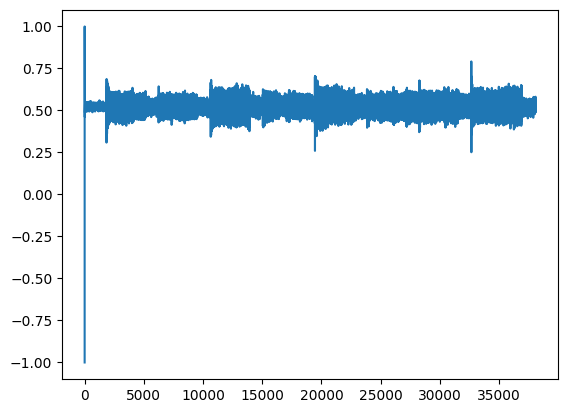

In [226]:
plt.plot(x)

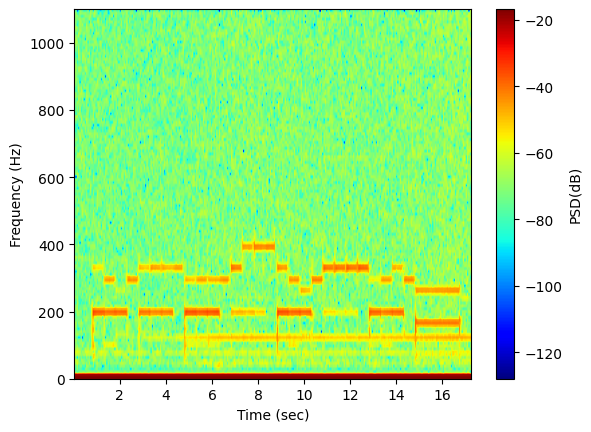

In [227]:
vm.plot_spectogram(x, 2200)

In [88]:
vm.save_audio('test.wav', x)

## 位相を変更

In [56]:
class VM:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.sr = 2200

    def align(self, x, y):
        # tshift = np.argmax(np.convolve(x, np.flip(y)))
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)
        
    def plot_spectogram(self, x, fs=2200, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            # sound = (sound-mins)/rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr=0):
        if sr==0:
            sr = self.sr
        # write(file_name, sr, x)
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor, sample_rate=2200):
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
       
        suc,frame = video.read() #reading first frame and considering it reference frame
       
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame
        
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        iter=1
        time_start = time()
        time_present=time()
        
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)
            
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
                
            suc,frame=video.read()
            time_present = time()
            
            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            # if iter==2200:
            #     break
            
        for band in pyramid.keys():
            # print(recovered_signal[band])
            plt.plot(range(1, len(recovered_signal[band])+1), recovered_signal[band])
            plt.show()
            self.plot_spectogram(recovered_signal[band])
            plt.show()
        # return      
        
        recov_sound=np.zeros(nframes)

        for rsignal in recovered_signal.values():
            if rsignal == recovered_signal['residual_lowpass']:
                continue
            recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))

        plt.plot(range(1, len(recov_sound)+1), recov_sound)
        plt.show()
        
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        
        return filtered_sound

Progress done: 1.3129217761205787% after 4.003760814666748s.
Progress done: 2.6258435522411574% after 8.012764692306519s.
Progress done: 3.938765328361736% after 12.019984722137451s.
Progress done: 5.251687104482315% after 16.044185161590576s.
Progress done: 6.564608880602894% after 20.06484818458557s.
Progress done: 7.877530656723472% after 24.041666984558105s.
Progress done: 9.190452432844051% after 28.05733036994934s.
Progress done: 10.50337420896463% after 32.08002042770386s.
Progress done: 11.816295985085208% after 36.10467600822449s.
Progress done: 13.129217761205789% after 40.123774766922s.
Progress done: 14.442139537326366% after 44.14356279373169s.
Progress done: 15.755061313446944% after 48.16657900810242s.
Progress done: 17.067983089567523% after 52.19715619087219s.
Progress done: 18.380904865688102% after 56.22942924499512s.
Progress done: 19.69382664180868% after 60.259836196899414s.
Progress done: 21.00674841792926% after 64.03679466247559s.
Progress done: 22.319670194049

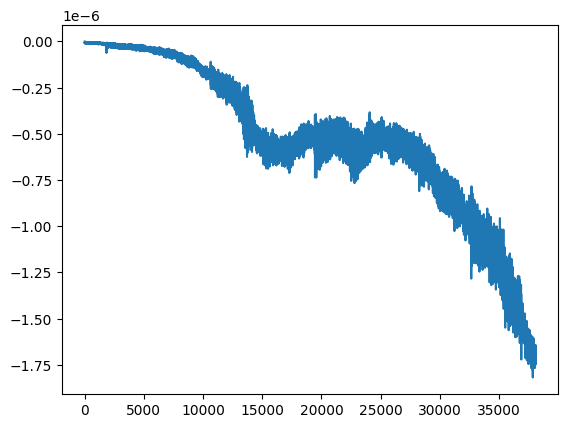

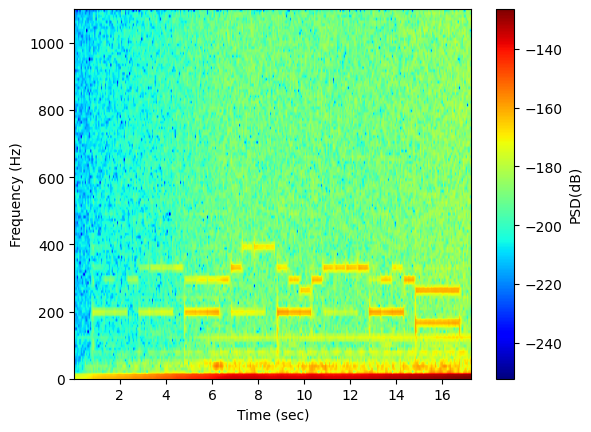

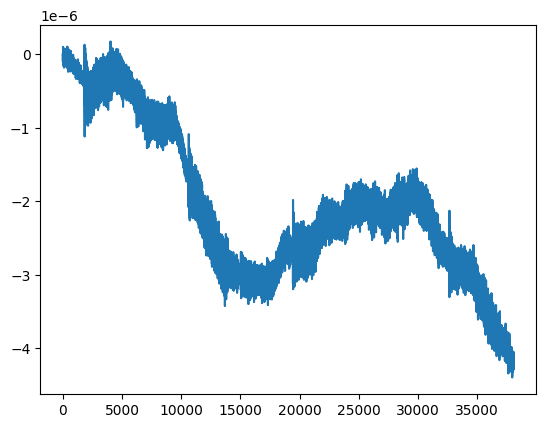

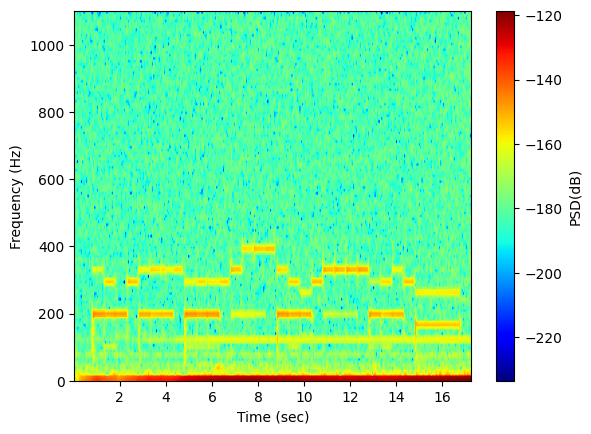

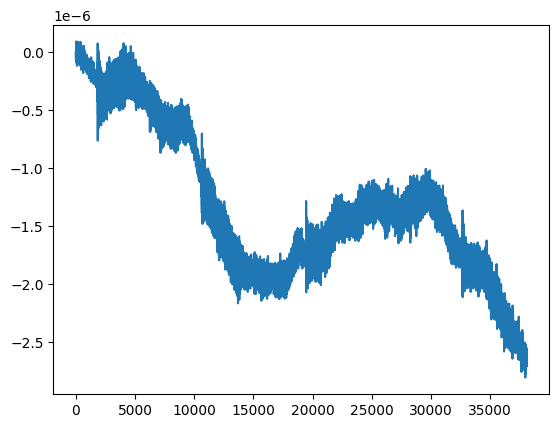

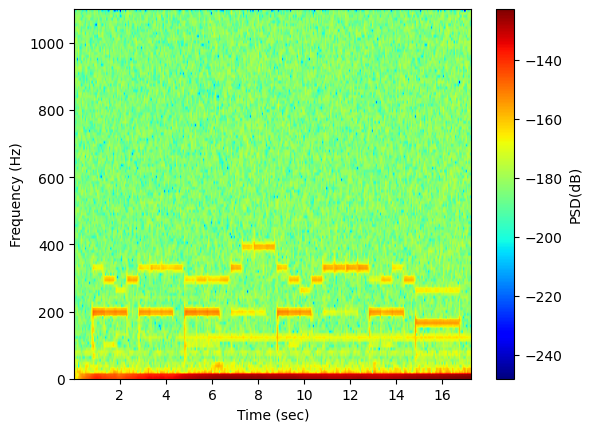

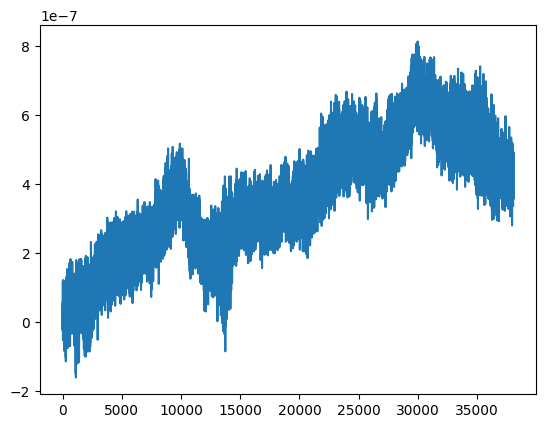

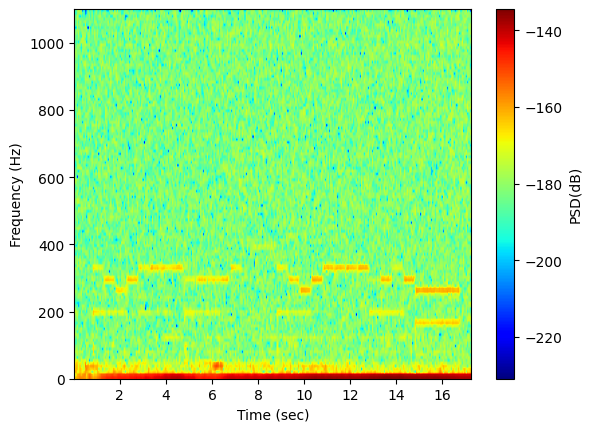

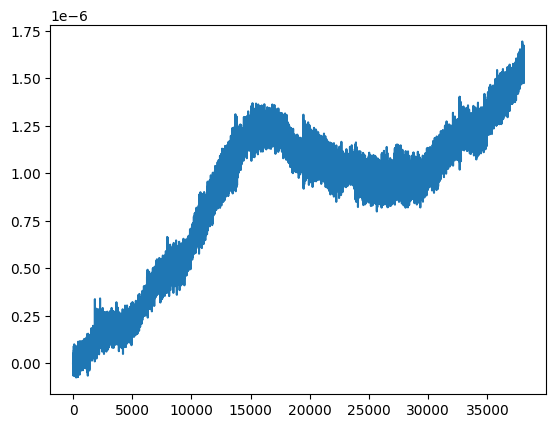

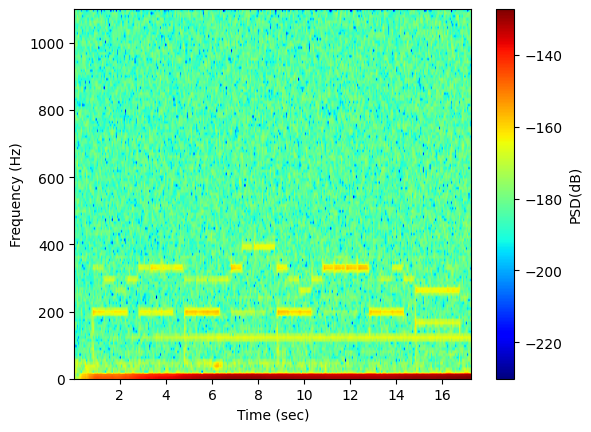

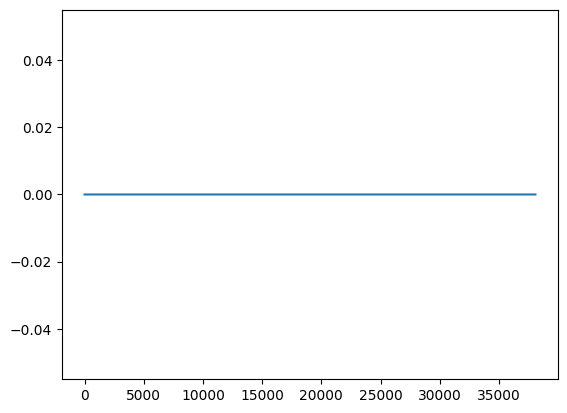

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


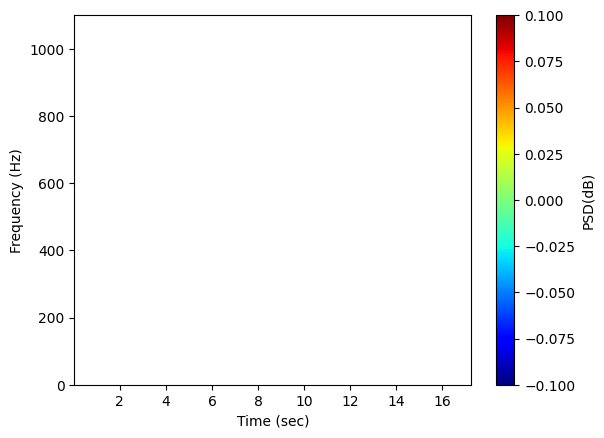

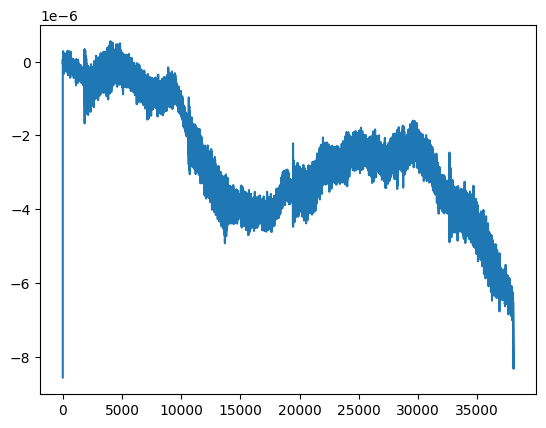

max: 2.340807076574011e-06, mins: -7.312961926632328e-06, rengev: 9.653769003206339e-06
     count          mean       std       min       25%       50%     75%  \
0  38083.0  2.358562e-07  0.047544 -1.515048 -0.031974 -0.000507  0.0321   

        max  
0  0.484952  


In [228]:
vm = VM(video_dir)
x = vm.sound_from_video(1, 4, 0.1)

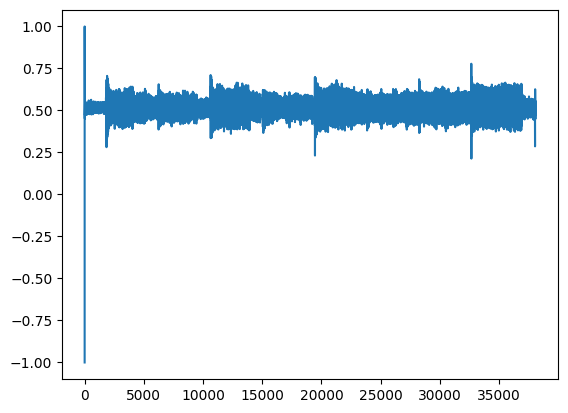

In [229]:
plt.plot(x)

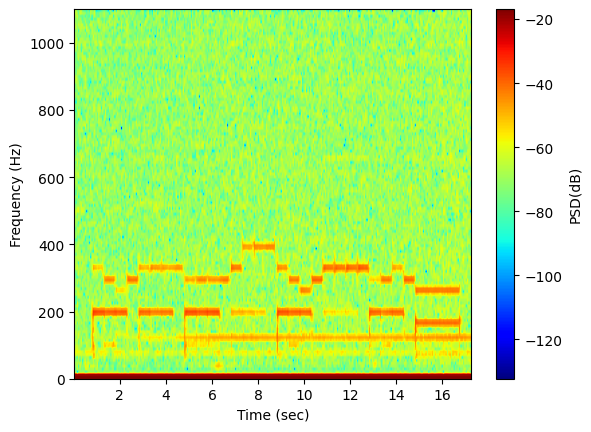

In [230]:
vm.plot_spectogram(x, 2200)

## 標準化を用いてみる

In [ ]:
class VM:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.sr = 2200

    def align(self, x, y):
        # tshift = np.argmax(np.convolve(x, np.flip(y)))
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)
        
    def plot_spectogram(self, x, fs=2200, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = (sound-mins)/rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr=0):
        if sr==0:
            sr = self.sr
        # write(file_name, sr, x)
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor, sample_rate=2200):
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object
       
        suc,frame = video.read() #reading first frame and considering it reference frame
       
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame
        
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        iter=1
        time_start = time()
        time_present=time()
        
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)
            
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
                
            suc,frame=video.read()
            time_present = time()
            
            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            # if iter==2200:
            #     break
            
        for band in pyramid.keys():
            # print(recovered_signal[band])
            plt.plot(range(1, len(recovered_signal[band])+1), recovered_signal[band])
            plt.show()
            self.plot_spectogram(recovered_signal[band])
            plt.show()
        # return      
        
        recov_sound=np.zeros(nframes)

        for rsignal in recovered_signal.values():
            if rsignal == recovered_signal['residual_lowpass']:
                continue
            recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
            print(f'recov_sound_max: {max(recov_sound)}, recov_sound_min: {min(recov_sound)}')
    
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        print(f'filtered_sound_max: {max(filtered_sound)}, filtered_sound_min: {min(filtered_sound)}')
        filtered_sound = self.get_scaled_sound(filtered_sound)
        print(f'filtered_sound_max: {np.max(filtered_sound)}, filtered_sound_min: {np.min(filtered_sound)}')
        
        return filtered_sound

# Rolling-Shutterを用いた抽出

In [5]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import librosa
import resampy
import scipy.stats

In [10]:
class VM_rolling:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.video_object.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.video_object.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.fps = int(self.video_object.get(cv2.CAP_PROP_FPS))
        print(self.width, self.height, self.fps)

    def align(self, x, y):
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)

    def plot_spectogram(self, x, fs, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim(0,1100)
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr):
        if sr==0:
            sr = self.sr
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor):
        ## 初期化
        nframes=self.nframes
        video=self.video_object
        
        ## 1フレーム目の読み出し
        suc,frame = video.read() #reading first frame and considering it reference frame

        ## ダウンサンプリング処理(画像サイズを小さくする)
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame

        ## gray画像にし、正規化する
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        ## SteerablePyramidを計算(初期フレームのみ)
        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs

        ## 初期化
        first_coeff=dict()
        recovered_signal=dict()
        N_gap = 312
        Num_signal = (self.height+N_gap)*nframes
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band] = [0] * Num_signal

        ## 時間とiterの初期化
        iter=1
        time_start = time()
        time_present=time()
        print(f'Steerable Pyramid 計算中')
        
        ## 各フレームで計算
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            
            amp_pyr=dict()
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)

            ## 初期フレームとの位相差を計算
            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi
            
            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]

                for y in range(len(amp[:,0])):
                    ## 重み付け
                    lms=np.multiply(phase_diff[:,y], np.multiply(amp[:,y], amp[:,y]))
                    amp_net = np.sum(amp[:,y])

                    ## 列情報を時間情報にする n=y+(H+N_gap)t
                    recovered_signal[band][y + (len(amp) + N_gap) * (iter - 2)] = np.mean(lms) / amp_net
            
            ## 次のフレームの読み込み
            suc,frame=video.read()
            time_present = time()

            ## 進捗の表示
            if(iter%50==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            # if iter==5:
            #     break

        ## 自己相関による補完
        time_present=time()
        for band in pyramid.keys():
            print(f'自己相関関数 計算中: {band}')
            for i in range(0, len(recovered_signal[band]), self.height+N_gap):
            # for i in range(0, 2000, self.height+N_gap):
                if band == 'residual_lowpass':
                    continue
                ar_model = AutoReg(recovered_signal[band][i:i+self.height], lags=150)
                # 選択された次数を用いてモデルの当てはめ
                ar_model = ar_model.fit()
                # 予測
                forecast = ar_model.forecast(N_gap)
                recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast 
                ## 進捗の表示
                if(i%100==0):
                    time_present=time()
                    print("Progress done: "+str(i/len(recovered_signal[band])*100)+"% "+"after "+str(time_present-time_start)+"s.")
        

        """
        for band in pyramid.keys():
            for i in range(0, len(recovered_signal[band]), self.height+N_gap):
            # for i in range(0, 2000, self.height+N_gap):
                if band == 'residual_lowpass':
                    continue
                ar_model = AutoReg(recovered_signal[band][i:i+self.height], lags=150)
                # 選択された次数を用いてモデルの当てはめ
                ar_model = ar_model.fit()
                # 予測
                forecast = ar_model.forecast(N_gap)
                recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast 

                # sel = ar_select_order(recovered_signal[band][i:i+self.height], maxlag=15, glob=True)
                # # 選択された次数を表示
                # print(sel.ar_lags)
                # # 選択された次数を用いてモデルの当てはめ
                # ar_model = sel.model.fit()
                # # 予測
                # forecast = ar_model.forecast(N_gap)
                # recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast
        """
        
        # グラフを表示
        for band in pyramid.keys():
            # sos = signal.butter(1, 0.05, btype='highpass', output='sos')
            # recovered_signal[band] = signal.sosfilt(sos, recovered_signal[band])
            
            # print(recovered_signal[band][:5000])
            plt.plot(range(0, Num_signal), recovered_signal[band][:Num_signal])
            # plt.plot(range(0, 2000), recovered_signal[band][0:2000])
            plt.show()
            y = resampy.resample(np.array(recovered_signal[band]), sr_orig=61920, sr_new=2200, filter='kaiser_best')
            self.plot_spectogram(y, 2200)
            plt.show()
        # return  
            
        ## 復元音声変数の初期化        
        recov_sound=np.zeros(len(recovered_signal[(0,0)]))   

        for rsignal in recovered_signal.values():
            if rsignal == recovered_signal['residual_lowpass']:
                continue
            # print(self.align(np.array(rsignal),np.array(recovered_signal[(0,0)])).shape)
            recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)])) 
            # recov_sound+=self.align(np.array(rsignal),np.array(recov_sound)) 
        
        ## 平均を取る
        recov_sound = recov_sound/(norientation+2)
        
        ## 合成振動の表示
        plt.plot(range(1, len(recov_sound)+1), recov_sound)
        plt.show()
            
        # ノイズ除去(ハイパスフィルタ)
        print('Denoising...')
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        
        ## スケーリング
        print('Scaling...')
        # filtered_sound = self.get_scaled_sound(recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        return filtered_sound

In [11]:
video_dir2 = 'KitKat-60Hz-RollingShutter-Mary_MIDI-input.avi'

In [12]:
vm_r = VM_rolling(video_dir2)

1280 720 59


Steerable Pyramid 計算中
Progress done: 4.595588235294118% after 8.271599769592285s.
Progress done: 9.191176470588236% after 16.702178478240967s.
Progress done: 13.786764705882353% after 25.145729780197144s.
Progress done: 18.38235294117647% after 33.524574279785156s.
Progress done: 22.977941176470587% after 41.93432641029358s.
Progress done: 27.573529411764707% after 50.32522177696228s.
Progress done: 32.169117647058826% after 58.92190885543823s.
Progress done: 36.76470588235294% after 67.26396083831787s.
Progress done: 41.36029411764706% after 75.58613324165344s.
Progress done: 45.955882352941174% after 83.9211015701294s.
Progress done: 50.55147058823529% after 92.23891806602478s.
Progress done: 55.14705882352941% after 100.56707334518433s.
Progress done: 59.74264705882353% after 109.61628079414368s.
Progress done: 64.33823529411765% after 118.2560658454895s.
Progress done: 68.93382352941177% after 127.20567035675049s.
Progress done: 73.52941176470588% after 136.07110810279846s.
Progres

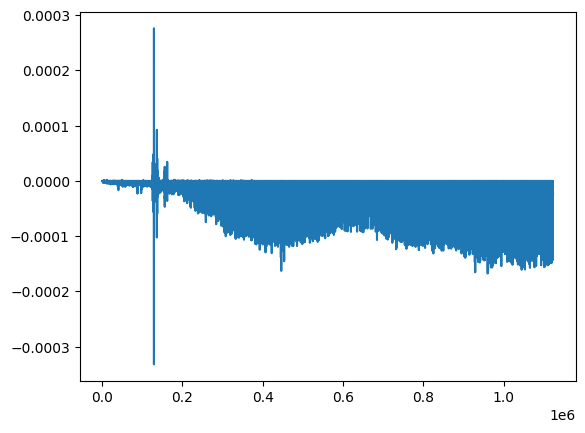

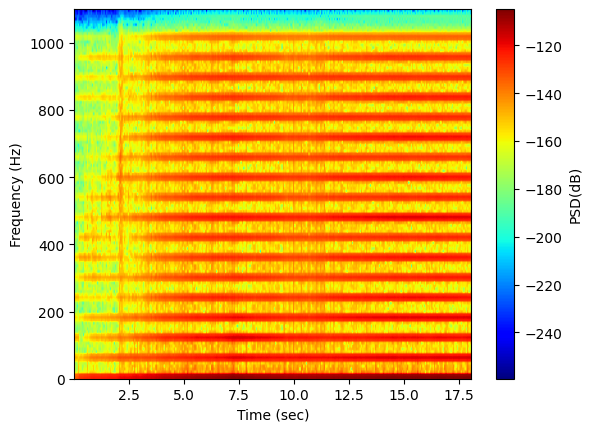

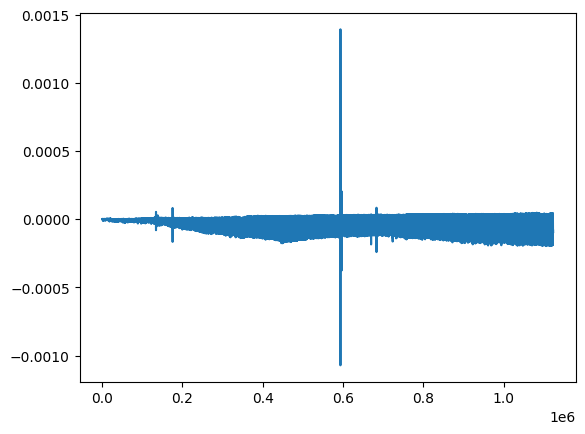

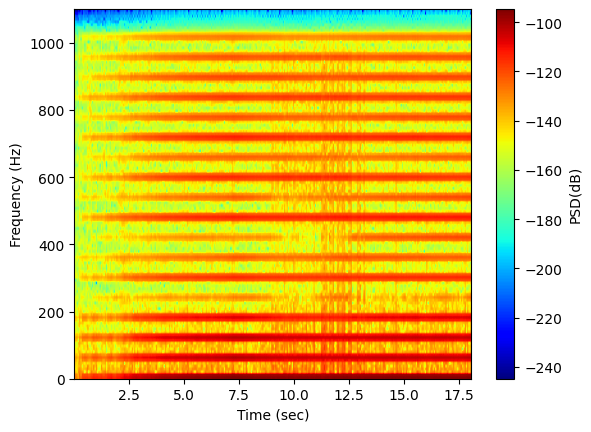

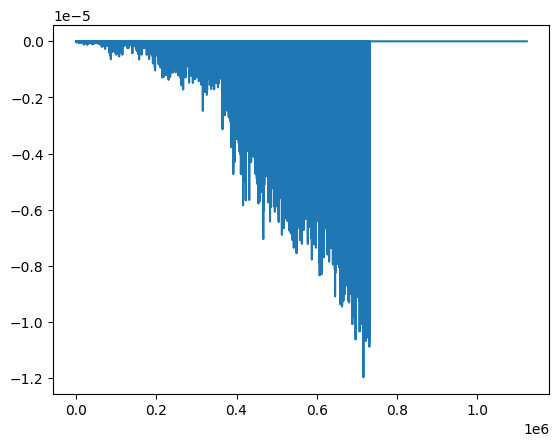

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


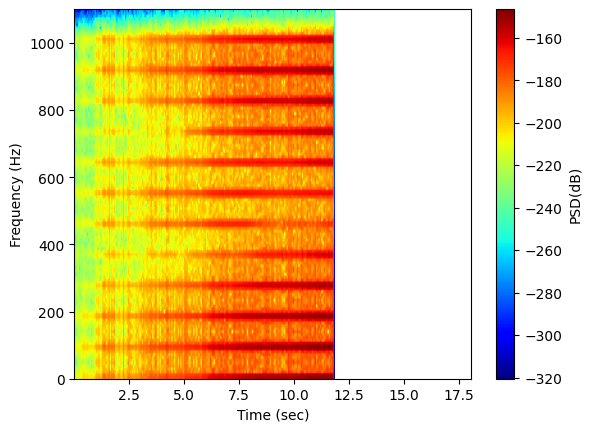

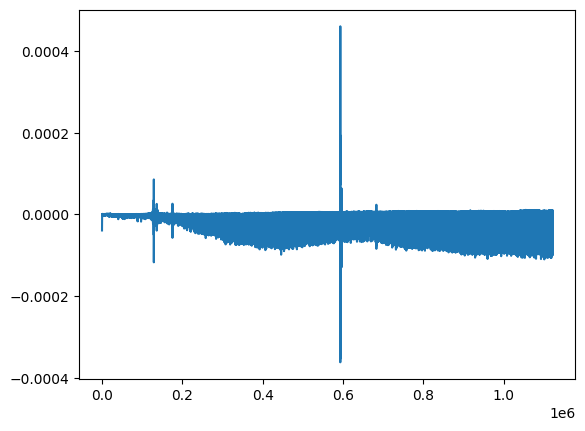

Denoising...
Scaling...
max: 0.0004946118359985712, mins: -0.0003423692982297079, rengev: 0.0008369811342282791
       count          mean       std       min       25%       50%       75%  \
0  1122816.0 -4.295058e-09  0.010327 -0.818105 -0.002591  0.000023  0.002872   

        max  
0  1.181895  


In [13]:
x_r = vm_r.sound_from_video(1, 1, 1)

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


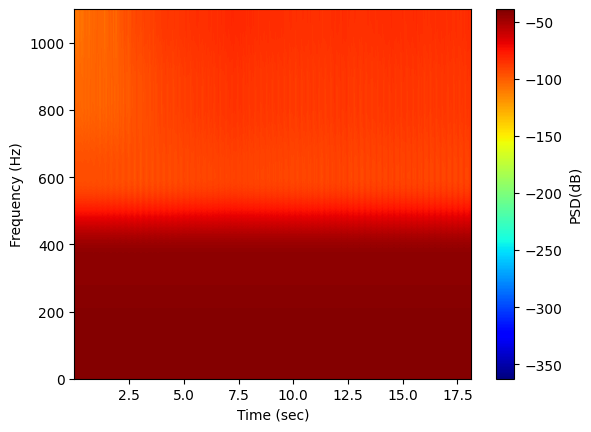

In [14]:
vm_r.plot_spectogram(x_r, 61920)

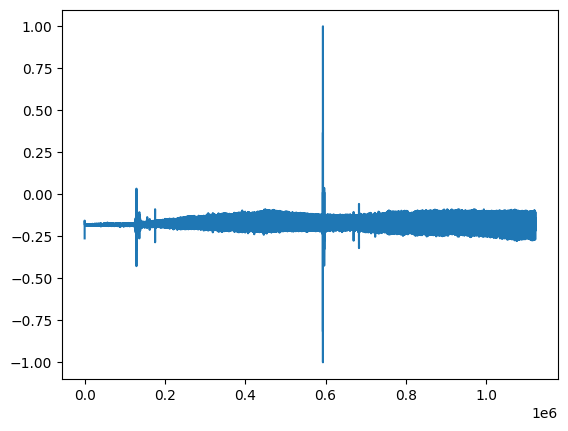

In [15]:
plt.plot(x_r)

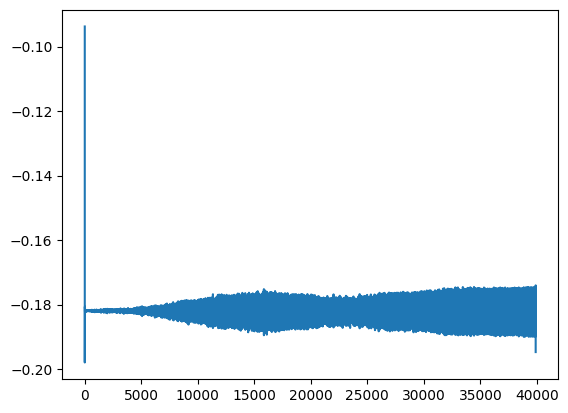

In [16]:
y = resampy.resample(x_r, sr_orig=61920, sr_new=2200)
plt.plot(y)

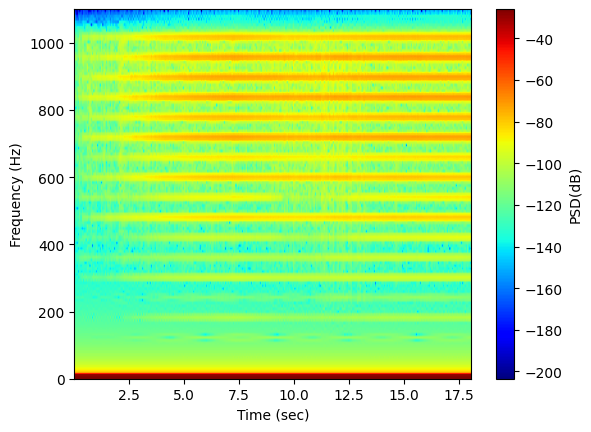

In [17]:
vm_r.plot_spectogram(y, 2200)

## 位相の変更

In [38]:
class VM_rolling:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.video_object.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.video_object.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.fps = int(self.video_object.get(cv2.CAP_PROP_FPS))
        print(self.width, self.height, self.fps)

    def align(self, x, y):
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)

    def plot_spectogram(self, x, fs, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim(0,1100)
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr):
        if sr==0:
            sr = self.sr
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor):
        ## 初期化
        nframes=self.nframes
        video=self.video_object
        
        ## 1フレーム目の読み出し
        suc,frame = video.read() #reading first frame and considering it reference frame

        ## ダウンサンプリング処理(画像サイズを小さくする)
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame

        ## gray画像にし、正規化する
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        ## SteerablePyramidを計算(初期フレームのみ)
        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs

        ## 初期化
        first_coeff=dict()
        recovered_signal=dict()
        N_gap = 312
        Num_signal = (self.height+N_gap)*nframes
        
        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band] = [0] * Num_signal
            # recovered_signal[band] = [None] * Num_signal

        ## 時間とiterの初期化
        iter=1
        time_start = time()
        time_present=time()
        print(f'Steerable Pyramid 計算中')
        
        ## 各フレームで計算
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            
            amp_pyr=dict()
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)

            ## 初期フレームとの位相差を計算
            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi
            
            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]

                for y in range(len(amp[:,0])):
                    ## 重み付け
                    lms=np.multiply(phase_diff[:,y], np.multiply(amp[:,y], amp[:,y]))
                    amp_net = np.sum(amp[:,y])

                    ## 列情報を時間情報にする n=y+(H+N_gap)t
                    recovered_signal[band][y + (len(amp) + N_gap) * (iter - 2)] = np.mean(lms) / amp_net
            
            ## 次のフレームの読み込み
            suc,frame=video.read()
            time_present = time()

            ## 進捗の表示
            if(iter%50==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            # if iter==10:
            #     break

        ## 自己相関による補完
        time_present=time()
        for band in pyramid.keys():
            print(f'自己相関関数 計算中: {band}')
            for i in range(0, len(recovered_signal[band]), self.height+N_gap):
            # for i in range(0, 5000, self.height+N_gap):
                if band == 'residual_lowpass':
                    continue
                ar_model = AutoReg(recovered_signal[band][i:i+self.height], lags=150)
                # 選択された次数を用いてモデルの当てはめ
                ar_model = ar_model.fit()
                # 予測
                forecast = ar_model.forecast(N_gap)
                recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast 
                ## 進捗の表示
                if(i%100==0):
                    time_present=time()
                    print("Progress done: "+str(i/len(recovered_signal[band])*100)+"% "+"after "+str(time_present-time_start)+"s.")
                    
                # sel = ar_select_order(recovered_signal[band][i:i+self.height], maxlag=15, glob=True)
                # # 選択された次数を表示
                # print(sel.ar_lags)
                # # 選択された次数を用いてモデルの当てはめ
                # ar_model = sel.model.fit()
                # # 予測
                # forecast = ar_model.forecast(N_gap)
                # recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast
                    
        # グラフを表示
        for band in pyramid.keys():
            # sos = signal.butter(1, 0.05, btype='highpass', output='sos')
            # recovered_signal[band] = signal.sosfilt(sos, recovered_signal[band])
            
            # print(recovered_signal[band][:5000])
            plt.plot(range(0, Num_signal), recovered_signal[band][:Num_signal])
            # plt.plot(range(0, 5000), recovered_signal[band][0:5000])
            plt.show()
            # self.plot_spectogram(recovered_signal[band], fs=61920)
            y = resampy.resample(np.array(recovered_signal[band]), sr_orig=61920, sr_new=2200, filter='kaiser_best')
            self.plot_spectogram(y, 2200)
            plt.show()
        # return  
            
        ## 復元音声変数の初期化        
        recov_sound=np.zeros(len(recovered_signal[(0,0)]))   

        for rsignal in recovered_signal.values():
            if rsignal == recovered_signal['residual_lowpass']:
                continue
            # print(self.align(np.array(rsignal),np.array(recovered_signal[(0,0)])).shape)
            # recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)])) 
            recov_sound+=self.align(np.array(rsignal),np.array(recov_sound)) 

        ## 合成振動の表示
        plt.plot(range(1, len(recov_sound)+1), recov_sound)
        plt.show()
            
        # ノイズ除去(ハイパスフィルタ)
        print('Denoising...')
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)

        """
        ## スケーリング
        print('Scaling...')
        # filtered_sound = self.get_scaled_sound(recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)
        """
        return filtered_sound

1280 720 59
Steerable Pyramid 計算中
自己相関関数 計算中: residual_highpass
Progress done: 0.0% after 1.6702401638031006s.
自己相関関数 計算中: (0, 0)
Progress done: 0.0% after 4.373508453369141s.
自己相関関数 計算中: residual_lowpass


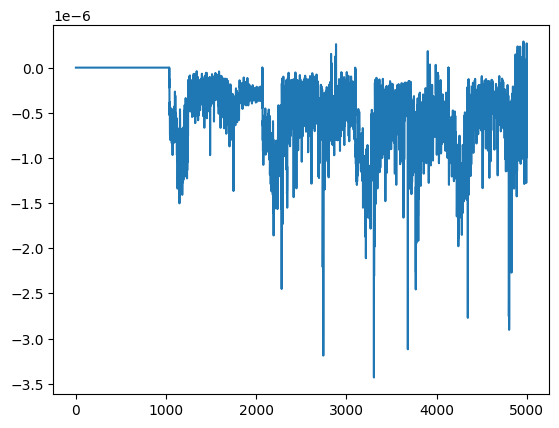

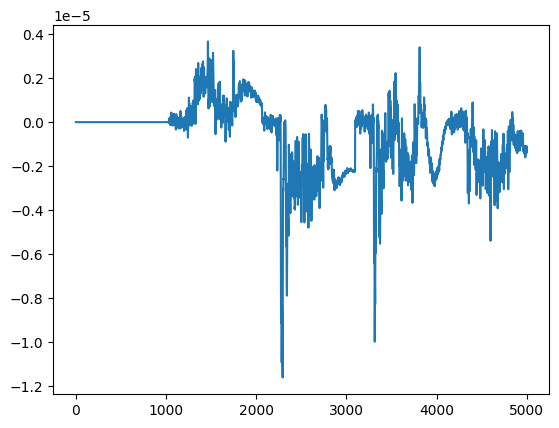

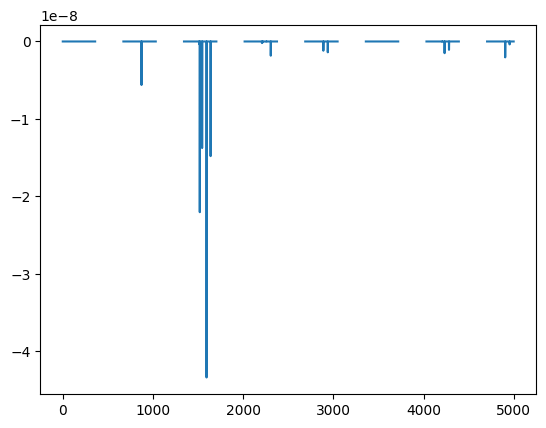

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [51]:
vm_r = VM_rolling(video_dir2)
x_r = vm_r.sound_from_video(1, 1, 1)

In [ ]:
vm_r.plot_spectogram(x_r, 61920)

In [ ]:
plt.plot(x_r)

In [ ]:
y = resampy.resample(x_r, sr_orig=61920, sr_new=2200)
plt.plot(y)

In [ ]:
vm_r.plot_spectogram(y, 2200)

1280 720 59
Steerable Pyramid 計算中
Progress done: 4.595588235294118% after 17.126498222351074s.
Progress done: 9.191176470588236% after 34.57281017303467s.
Progress done: 13.786764705882353% after 52.56531882286072s.
Progress done: 18.38235294117647% after 70.18974304199219s.
Progress done: 22.977941176470587% after 88.21667981147766s.
Progress done: 27.573529411764707% after 106.2471992969513s.
Progress done: 32.169117647058826% after 123.91107392311096s.
Progress done: 36.76470588235294% after 141.39704704284668s.
Progress done: 41.36029411764706% after 159.4509882926941s.
Progress done: 45.955882352941174% after 176.9339530467987s.
Progress done: 50.55147058823529% after 194.2630898952484s.
Progress done: 55.14705882352941% after 211.74145078659058s.
Progress done: 59.74264705882353% after 229.17460918426514s.
Progress done: 64.33823529411765% after 246.55841159820557s.
Progress done: 68.93382352941177% after 264.09809374809265s.
Progress done: 73.52941176470588% after 281.3841512203

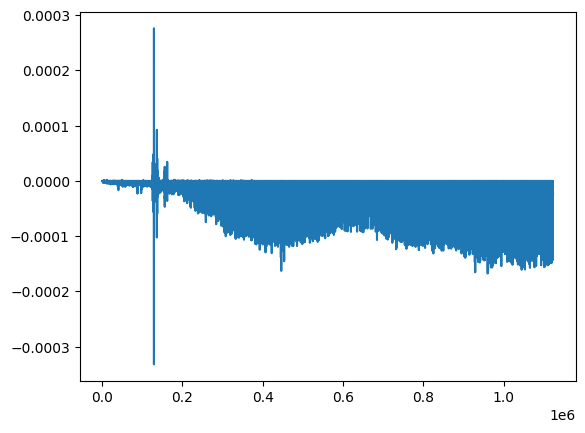

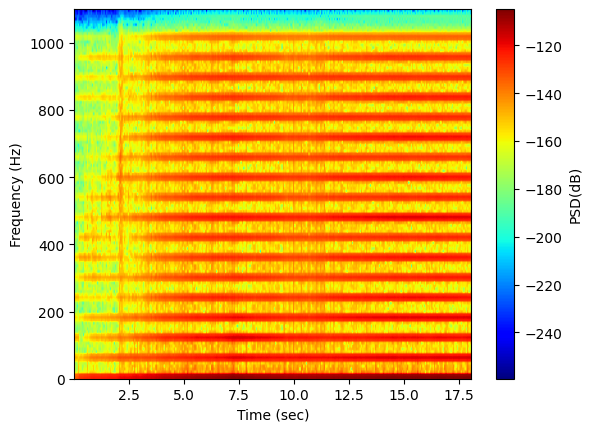

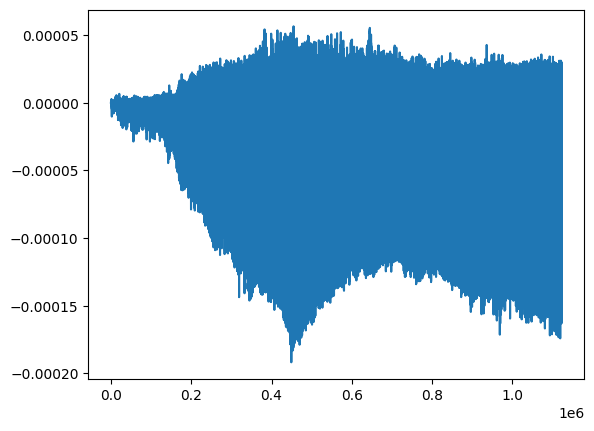

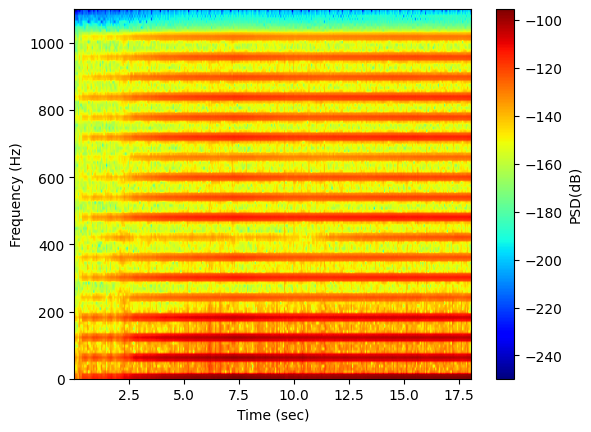

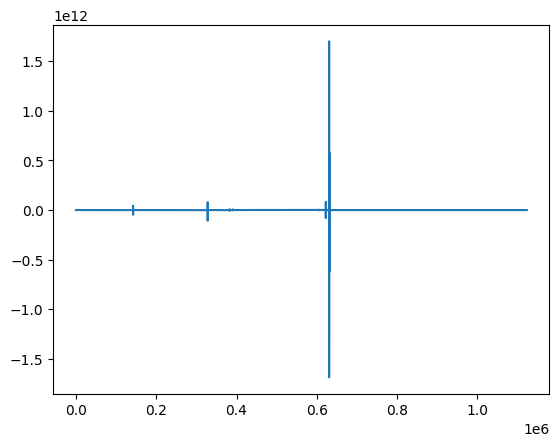

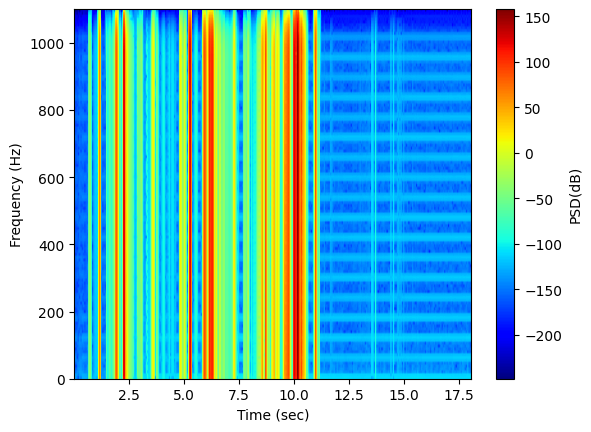

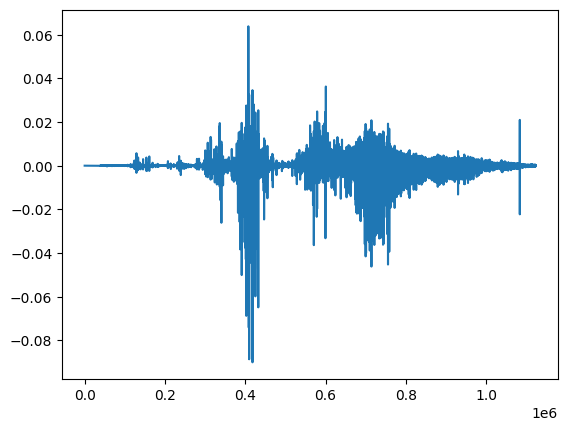

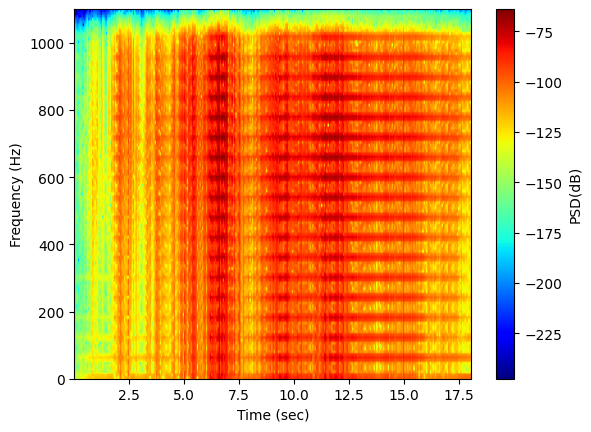

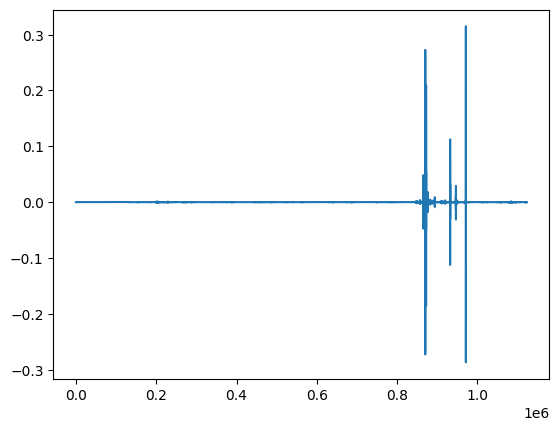

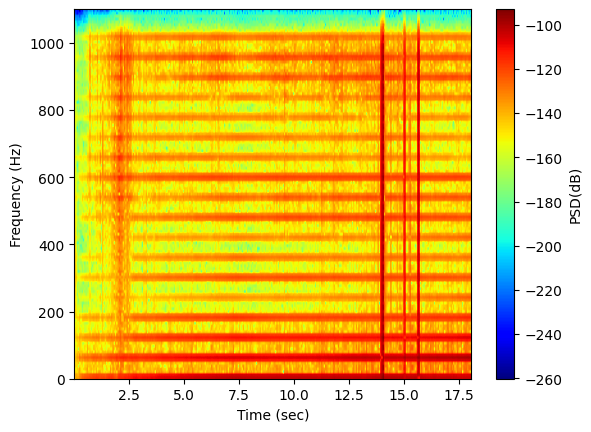

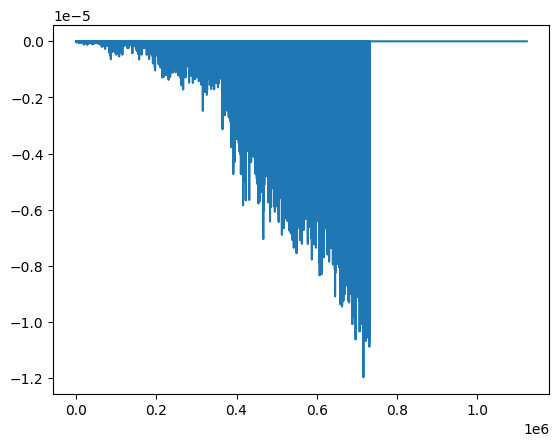

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


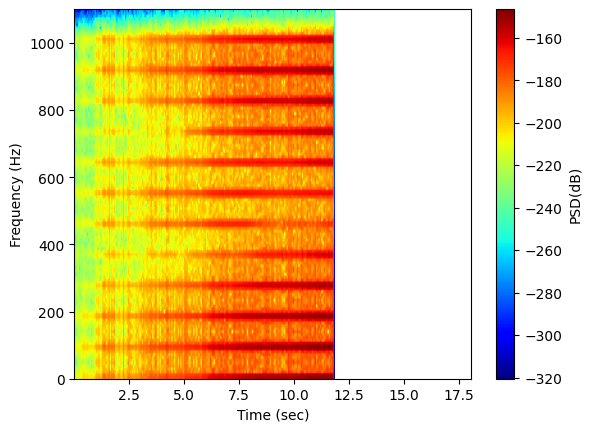

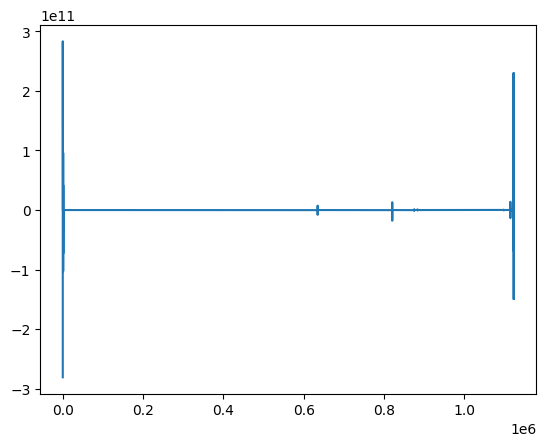

Denoising...
Scaling...
max: 317417722593.17487, mins: -239996604320.60165, rengev: 557414326913.7765
       count          mean       std       min           25%           50%  \
0  1122816.0  4.162521e-07  0.002143 -0.861107 -9.033358e-18  2.622443e-20   

            75%       max  
0  8.167229e-18  1.138893  


In [18]:
vm_r = VM_rolling(video_dir2)
x_r = vm_r.sound_from_video(1, 4, 1)

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


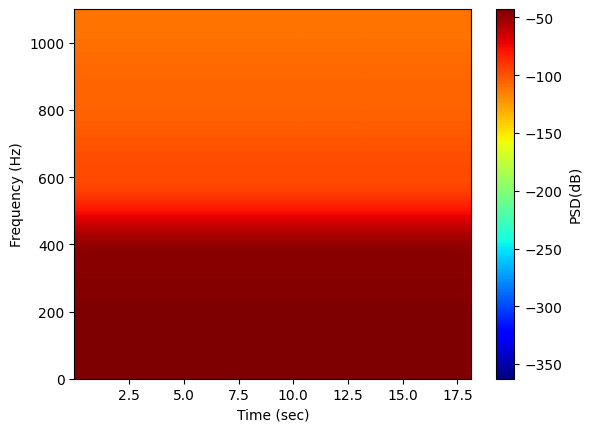

In [19]:
vm_r.plot_spectogram(x_r, 61920)

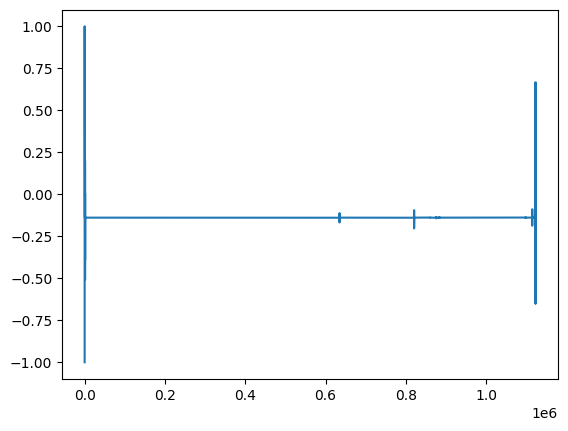

In [20]:
plt.plot(x_r)

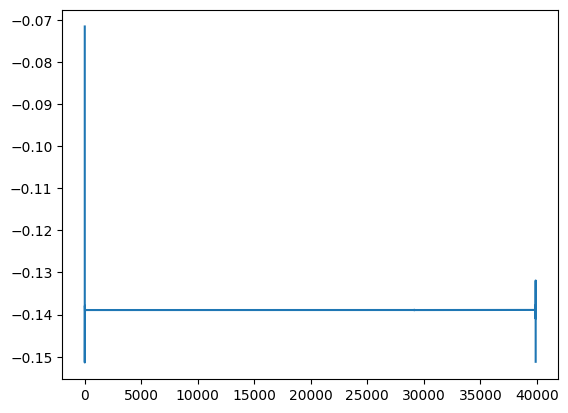

In [21]:
y = resampy.resample(x_r, sr_orig=61920, sr_new=2200)
plt.plot(y)

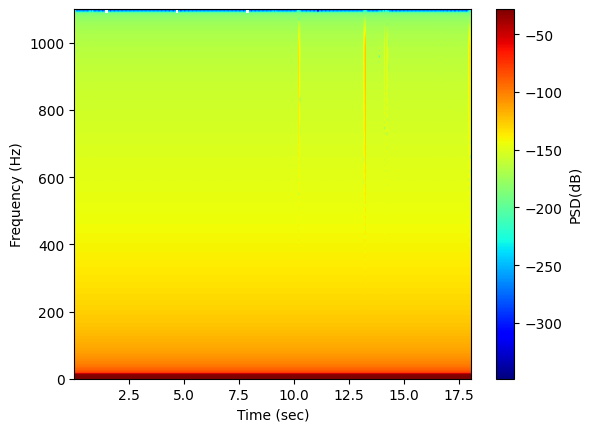

In [22]:
vm_r.plot_spectogram(y, 2200)

In [44]:
print(pd.DataFrame(pd.Series(x_r.ravel()).describe()).transpose())

       count          mean           std           min       25%  \
0  1122816.0  4.228296e-08  3.606993e+09 -1.669365e+12 -0.000014   

            50%       75%           max  
0  1.081698e-08  0.000013  1.711265e+12  


In [211]:
x_r_copy = scipy.stats.zscore(x_r)

In [207]:
x_r_copy[np.argmax(x_r_copy)]=0

In [208]:
x_r_copy[np.argmin(x_r_copy)]=0

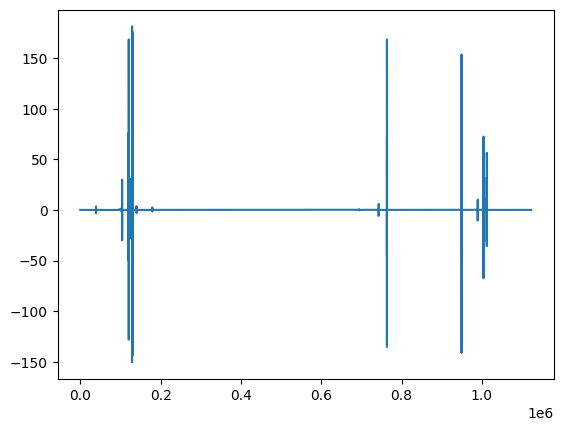

In [212]:
plt.plot(x_r_copy)

## pyramidの複数スケール実装

In [1]:
import pyrtools as pt
import cv2
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import librosa
import resampy
import scipy.stats

In [37]:
class VM_rolling:
    def __init__(self, video_path):
        self.video_object = cv2.VideoCapture(video_path)
        self.nframes = nframes = int(self.video_object.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.video_object.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.video_object.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.fps = int(self.video_object.get(cv2.CAP_PROP_FPS))
        print(self.width, self.height, self.fps)

    def align(self, x, y):
        tshift = np.argmax(signal.fftconvolve(x, np.flip(y)))
        shift = y.size - tshift
        return np.roll(x,shift)

    def plot_spectogram(self, x, fs, save=False):
        plt.figure()
        plt.specgram(x, Fs=fs, cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim(0,1100)
        plt.colorbar().set_label('PSD(dB)')
        plt.savefig("spectrogram")

    def get_scaled_sound(self, sound):
        maxs = np.max(sound)
        mins = np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs - mins
            print(f'max: {maxs}, mins: {mins}, rengev: {rangev}')
            sound = 2 * sound / rangev
            print(pd.DataFrame(pd.Series(sound.ravel()).describe()).transpose())
            newmax = np.max(sound)
            offset = newmax - 1.0
            sound -= offset

        return sound

    def save_audio(self, file_name, sound, sr):
        if sr==0:
            sr = self.sr
        write(file_name, sr, sound)

    def sound_from_video(self, nscale, norientation, downsample_factor):
        ## 初期化
        nframes=self.nframes
        video=self.video_object
        
        ## 1フレーム目の読み出し
        suc,frame = video.read() #reading first frame and considering it reference frame

        ## ダウンサンプリング処理(画像サイズを小さくする)
        if downsample_factor < 1:
            scaled_frame = cv2.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame

        ## gray画像にし、正規化する
        gray_frame = cv2.cvtColor(scaled_frame, cv2.COLOR_BGR2GRAY)
        norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

        ## SteerablePyramidを計算(初期フレームのみ)
        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs

        ## 初期化
        first_coeff=dict()
        recovered_signal=dict()
        N_gap = 312
        Num_signal = (self.height+N_gap)*nframes
        
        for band,coefficient in first_pyr.items():
            if band == 'residual_lowpass':
                continue
            if band == 'residual_highpass':
                continue
            first_coeff[band]=coefficient
            recovered_signal[band] = [0] * Num_signal
            # recovered_signal[band] = [None] * Num_signal

        ## 時間とiterの初期化
        iter=1
        time_start = time()
        time_present=time()
        print(f'Steerable Pyramid 計算中')
        
        ## 各フレームで計算
        while suc: #iterating over each frame
            iter+=1
            
            if downsample_factor < 1:
                frame = cv2.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)
            
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            norm_frame = cv2.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            
            amp_pyr=dict()
            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                if band == 'residual_lowpass':
                    continue
                if band == 'residual_highpass':
                    continue
                amp_pyr[band] = abs(coefficient)

            ## 初期フレームとの位相差を計算
            for band,coefficient in pyramid.items():
                if band == 'residual_lowpass':
                    continue
                if band == 'residual_highpass':
                    continue
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi
            
            # for band in recovered_signal:
            #     amp=amp_pyr[band]
            #     phase_diff=phase_diff_pyr[band]

            #     for y in range(len(amp[:,0])):
            #         ## 重み付け
            #         lms=np.multiply(phase_diff[:,y], np.multiply(amp[:,y], amp[:,y]))
            #         amp_net = np.sum(amp[:,y])

            #         ## 列情報を時間情報にする n=y+(H+N_gap)t
            #         recovered_signal[band][y + (len(amp) + N_gap) * (iter - 2)] = np.mean(lms) / amp_net
                    
            for band in recovered_signal:
                amp = amp_pyr[band]
                phase_diff = phase_diff_pyr[band]
                print(band)

                idx_offset = 0  # このオフセットを使用してインデックスの重複を防ぐ
                
                for y in range(len(amp[:, 0])):
                    ## 重み付け
                    lms = np.multiply(phase_diff[:, y], np.multiply(amp[:, y], amp[:, y]))
                    amp_net = np.mean(lms) / np.sum(amp[:, y])
                    
                    # bandの値に基づいて、繰り返し回数を設定
                    repeat_count = 2 ** band[0]
            
                    # 指定された回数だけ同じ値を代入
                    for i in range(1, repeat_count+1):
                        # index = y + (len(amp) + N_gap) * (iter - 2) + i
                        # index = y + (len(amp) + N_gap) * (iter - 2) + idx_offset + i-1
                        index = y + 1032 * (iter - 2) + idx_offset + i-1
                        if(iter==3): print(index)
                        recovered_signal[band][index] = amp_net 
                    idx_offset += repeat_count-1

                # print(recovered_signal[band][1000:2000])
            # return
                    
                # s = pd.Series(recovered_signal[band])
                # s.iloc[:(720+312)* (iter - 2)] = s.iloc[:(720+312)* (iter - 2)].fillna(method='ffill').fillna(method='bfill')  
                # recovered_signal[band] = s.tolist()    
                
                # 最も長い要素の長さを取得
                # max_length = max([len(v) for v in recovered_signal.values()])
                
                # それぞれの要素を線形補間して最大の長さに合わせる
                # for key in recovered_signal:
                #     old_length = len(recovered_signal[key])
                #     x_old = np.linspace(0, 1, old_length)
                #     x_new = np.linspace(0, 1, max_length)
                #     recovered_signal[key] = np.interp(x_new, x_old, recovered_signal[key])

                # それぞれの要素を最大の長さに合わせて最後の値で埋める
                # for key in recovered_signal:
                #     last_value = recovered_signal[key][-1]
                #     pad_length = max_length - len(recovered_signal[key])
                #     recovered_signal[key] = np.concatenate((recovered_signal[key], np.full(pad_length, last_value)))
            
            ## 次のフレームの読み込み
            suc,frame=video.read()
            time_present = time()

            ## 進捗の表示
            if(iter%50==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
            if iter==10:
                break
        
        # グラフを表示
        print("自己相関処理前")
        for band in recovered_signal:
            # if band == "(0, 0)":
            #     continue
            # print(recovered_signal[band][:5000])
            # plt.plot(range(0, Num_signal), recovered_signal[band][:Num_signal])
            plt.plot(range(0, 5000), recovered_signal[band][0:5000])
            plt.show()
        
        

        ## 自己相関による補完
        time_present=time()
        for band in recovered_signal:
            print(f'自己相関関数 計算中: {band}')
            # for i in range(0, len(recovered_signal[band]), self.height+N_gap):
            for i in range(0, 5000, self.height+N_gap):
                ar_model = AutoReg(recovered_signal[band][i:i+self.height], lags=150)
                # 選択された次数を用いてモデルの当てはめ
                ar_model = ar_model.fit()
                # 予測
                forecast = ar_model.forecast(N_gap)
                recovered_signal[band][i+self.height:i+self.height+N_gap] = forecast 
                ## 進捗の表示
                if(i%100==0):
                    time_present=time()
                    print("Progress done: "+str(i/len(recovered_signal[band])*100)+"% "+"after "+str(time_present-time_start)+"s.")
                    
        # グラフを表示
        print("自己相関処理後")
        for band in recovered_signal:
            # print(recovered_signal[band][:5000])
            # plt.plot(range(0, Num_signal), recovered_signal[band][:Num_signal])
            plt.plot(range(0, 5000), recovered_signal[band][0:5000])
            plt.show()
            # self.plot_spectogram(recovered_signal[band], fs=61920)
            y = resampy.resample(np.array(recovered_signal[band]), sr_orig=61920, sr_new=2200, filter='kaiser_best')
            # self.plot_spectogram(y, 2200)
            plt.show()
        return  
            
        ## 復元音声変数の初期化        
        recov_sound=np.zeros(len(recovered_signal[(0,0)]))   

        num = 0
        for rsignal in recovered_signal.values():
            # if np.array_equal(rsignal, recovered_signal['residual_lowpass']):
            #     continue
            recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)])) 
            num += 1
        recov_sound = recov_sound / num
            
        ## 合成振動の表示
        plt.plot(range(1, len(recov_sound)+1), recov_sound)
        plt.show()
            
        # ノイズ除去(ハイパスフィルタ)
        print('Denoising...')
        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)

        
        ## スケーリング
        print('Scaling...')
        filtered_sound = self.get_scaled_sound(filtered_sound)
    
        return filtered_sound

In [38]:
video_dir2 = 'KitKat-60Hz-RollingShutter-Mary_MIDI-input.avi'

1280 720 59
Steerable Pyramid 計算中
(0, 0)
(1, 0)
(2, 0)
(3, 0)
(4, 0)
(0, 0)
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216

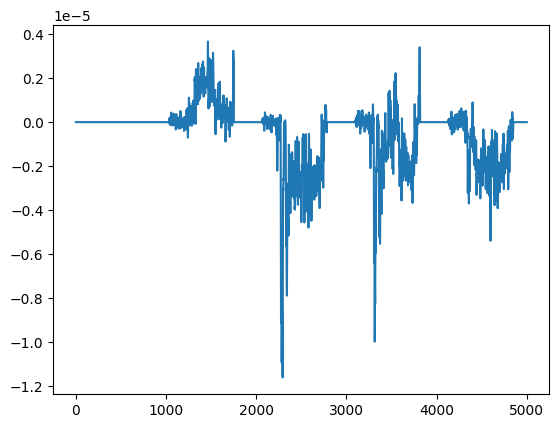

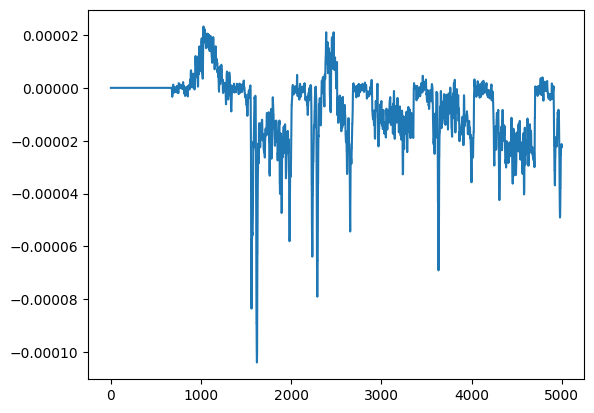

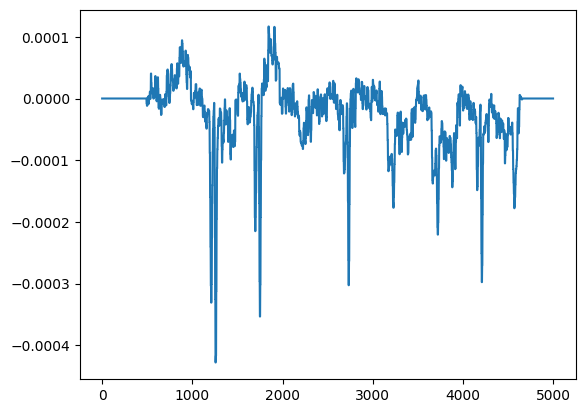

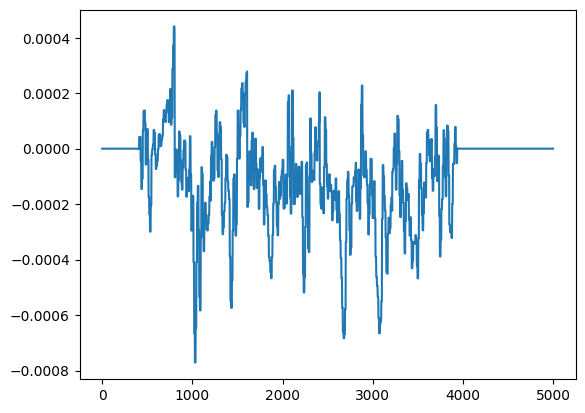

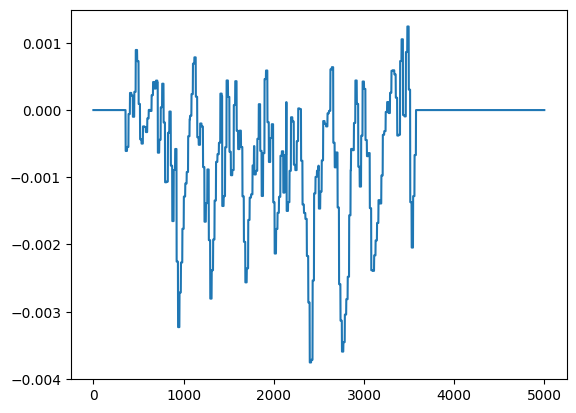

自己相関関数 計算中: (0, 0)
Progress done: 0.0% after 2.4552693367004395s.
自己相関関数 計算中: (1, 0)
Progress done: 0.0% after 4.452787160873413s.
自己相関関数 計算中: (2, 0)
Progress done: 0.0% after 6.452929735183716s.
自己相関関数 計算中: (3, 0)
Progress done: 0.0% after 8.05106806755066s.
自己相関関数 計算中: (4, 0)
Progress done: 0.0% after 9.557915925979614s.
自己相関処理後


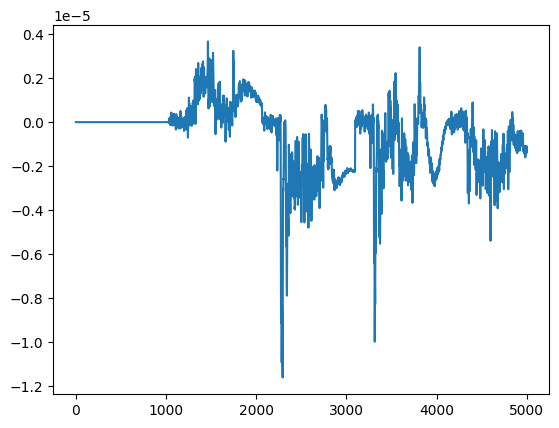

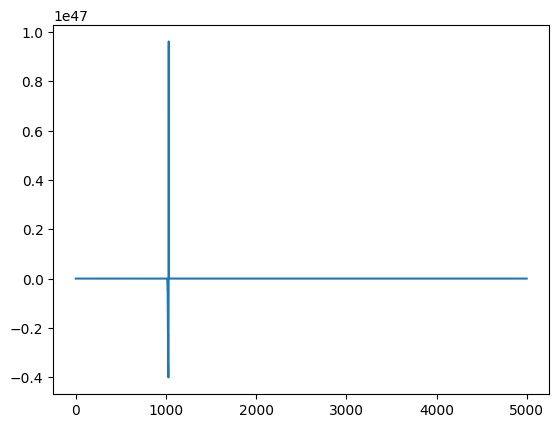

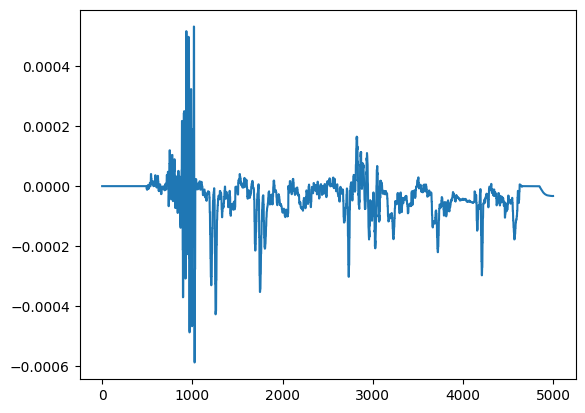

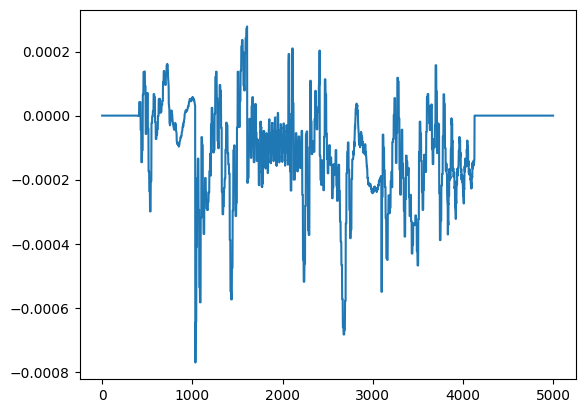

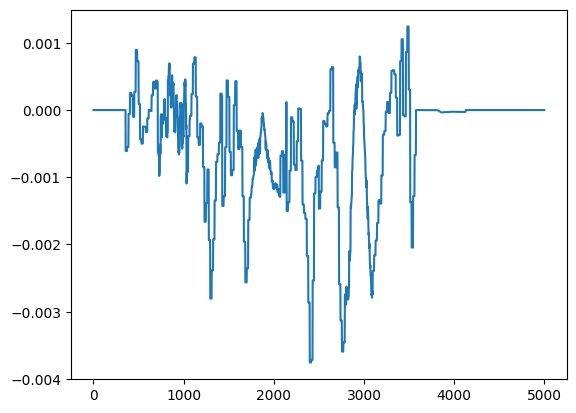

In [39]:
vm_r = VM_rolling(video_dir2)
x_r = vm_r.sound_from_video(5, 1, 1)

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


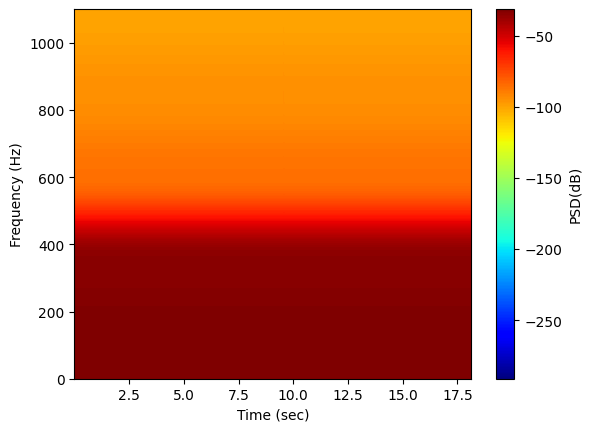

In [62]:
vm_r.plot_spectogram(x_r, 61920)

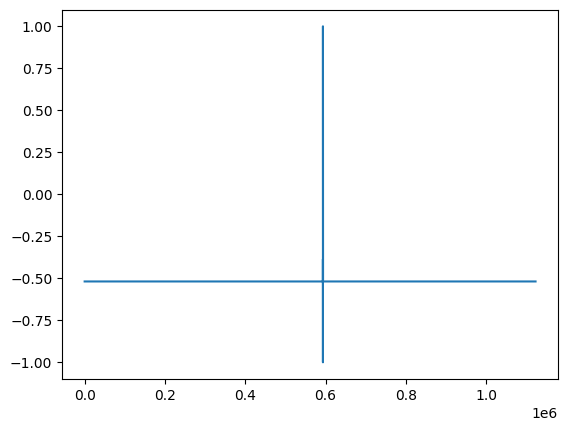

In [63]:
plt.plot(x_r)

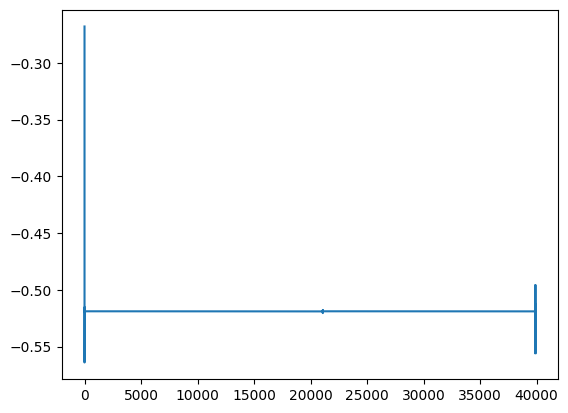

In [64]:
y = resampy.resample(x_r, sr_orig=61920, sr_new=2200)
plt.plot(y)

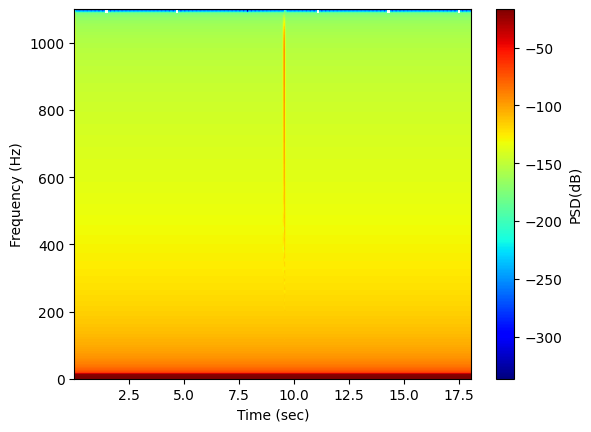

In [65]:
vm_r.plot_spectogram(y, 2200)

In [170]:
sos = signal.butter(100, 0.5, btype='highpass', output='sos')
test = signal.sosfilt(sos, x_r)

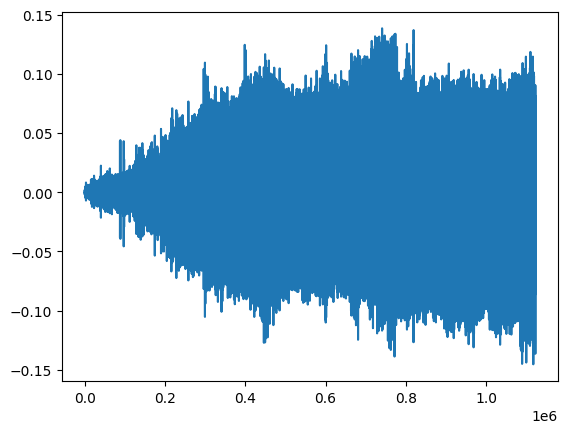

In [171]:
plt.plot(test)

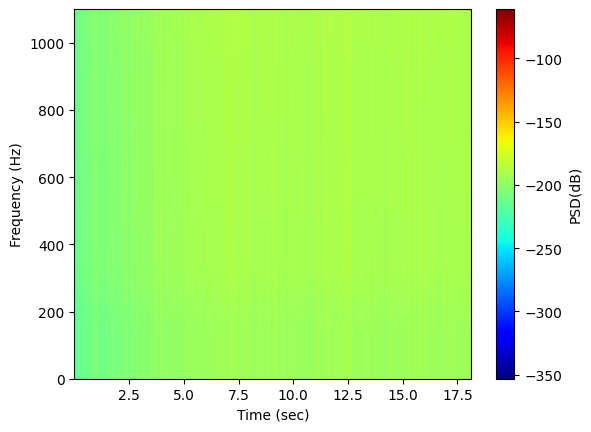

In [172]:
vm_r.plot_spectogram(test, 61920)

In [181]:
sos = signal.butter(4, 0.05, btype='lowpass', output='sos')
test = signal.sosfilt(sos, x_r)

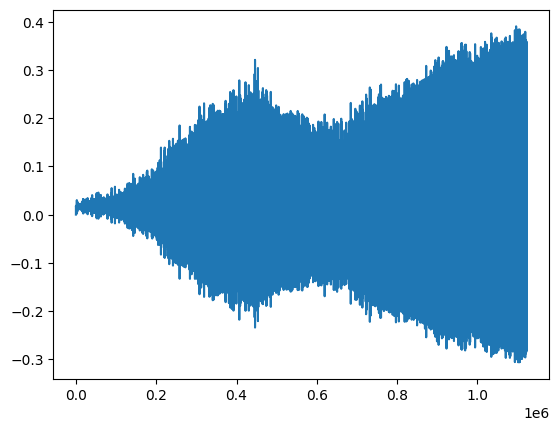

In [182]:
plt.plot(test)

(array([2.10000e+01, 4.50000e+01, 6.80000e+01, 2.70000e+02, 5.36000e+02,
        9.57000e+02, 3.47900e+03, 1.78530e+04, 5.95810e+04, 1.56081e+05,
        7.81318e+05, 6.94740e+04, 2.01380e+04, 6.71600e+03, 2.84000e+03,
        1.49700e+03, 6.35000e+02, 5.20000e+02, 3.68000e+02, 1.07000e+02]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

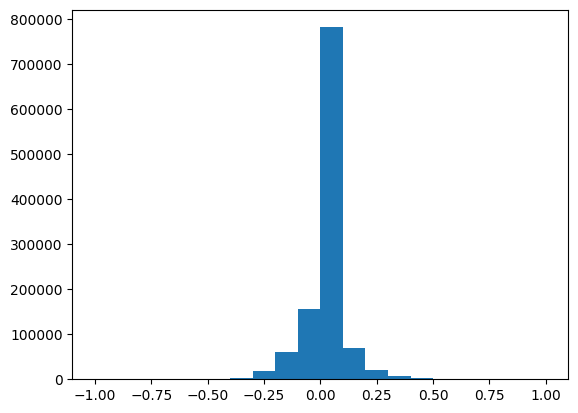

In [101]:
plt.hist(x_r, bins=20)

(array([-24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24]),
 array([-0.02502889, -0.07262171, -0.09380388, -0.08402163, -0.07341484,
        -0.09293441, -0.13134596, -0.17022794, -0.19171673, -0.20138568,
        -0.20197092, -0.20379891, -0.21291759, -0.2207337 , -0.19679131,
        -0.11189706, -0.00239641,  0.08082396,  0.11755285,  0.13261526,
         0.16466906,  0.29495322,  0.52028522,  0.80293361,  1.        ,
         0.80293361,  0.52028522,  0.29495322,  0.16466906,  0.13261526,
         0.11755285,  0.08082396, -0.00239641, -0.11189706, -0.19679131,
        -0.2207337 , -0.21291759, -0.20379891, -0.20197092, -0.20138568,
        -0.19171673, -0.17022794, -0.13134596, -0.09293441, -0.07341484,
        -0.08402163, -0.09380388, -0.07262171, -0.02502889]),
 <

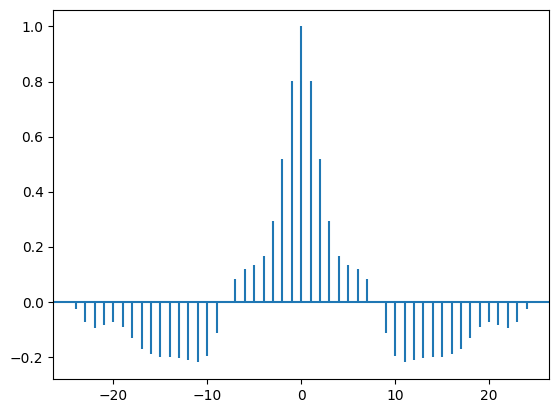

In [106]:
plt.acorr(x_r, maxlags=24)

In [6]:
vm_r.save_audio('test3.wav', x_r, sr=61920)

In [107]:
plt.savefig('corr2')

<Figure size 640x480 with 0 Axes>

In [63]:
vm_r.save_audio('test6.wav', y, sr=2200)

In [ ]:
import cv2
import numpy as np
from pyrtools import pyramids

# Load your video here
cap = cv2.VideoCapture('your_video.mp4')

# Initialize the previous frame's decomposed image
prev_decomposed_image = None

# Loop over each frame in the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Create a Steerable Pyramid and decompose the frame
    pyramid = pyramids.SteerablePyramid(gray, height=5, order=3)
    decomposed_image = pyramid.pyr_coeffs

    # If this is not the first frame, compute the phase difference at different positions
    if prev_decomposed_image is not None:
        # Initialize an array to store the phase differences
        phase_diffs = np.zeros_like(gray, dtype=np.float32)

        # Compute the phase difference at each position
        for i in range(gray.shape[0]):
            phase_diffs[i] = np.angle(decomposed_image[i]) - np.angle(prev_decomposed_image[i])

        # Here you can do something with the phase differences, e.g., store them, visualize them, etc.

    # Update the previous frame's decomposed image
    prev_decomposed_image = decomposed_image

# Release the video capture
cap.release()
